In [124]:
# Import libraries
import os
import pandas as pd
import numpy as np


from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.datasets import make_classification
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.inspection import permutation_importance

import matplotlib.pyplot as plt
import seaborn as sns

# Access data using Google BigQuery.
from google.colab import auth
from google.cloud import bigquery

In [2]:
# Load the Drive helper and mount
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/My Drive/MLA4H/project

/content/drive/My Drive/MLA4H/project


# 1. Read Processed CSV

In [281]:
df = pd.read_csv('data/processed_Op_Hp_LabEvents.csv')
df.tail(5)

,max_FreeCalcium1,min_FreeCalcium1,avg_FreeCalcium1,max_25OHVitaminD,min_25OHVitaminD,avg_25OHVitaminD,max_CalciumTotal,min_CalciumTotal,avg_CalciumTotal,max_CalciumUrine,min_CalciumUrine,avg_CalciumUrine,max_ParathyroidHormone,min_ParathyroidHormone,avg_ParathyroidHormone,anchor_age,gender,Osteoporosis,Hyperparathyroidism
290501,1.17,1.07,1.12,24.0,24.0,24.0,8.5,8.5,8.5,3.4,3.2,3.3,86.0,74.0,81.0,34,1,0,0
290502,1.17,1.07,1.12,24.0,24.0,24.0,9.2,9.2,9.2,3.4,3.2,3.3,86.0,74.0,81.0,85,0,1,0
290503,1.17,1.07,1.12,24.0,24.0,24.0,8.4,8.4,8.4,3.4,3.2,3.3,86.0,74.0,81.0,50,0,0,0
290504,1.17,1.07,1.12,24.0,24.0,24.0,8.5,8.5,8.5,3.4,3.2,3.3,86.0,74.0,81.0,57,1,0,0
290505,1.17,1.07,1.12,24.0,24.0,24.0,8.6,8.6,8.6,3.4,3.2,3.3,86.0,74.0,81.0,64,0,0,0


In [282]:
print(pd.crosstab(df['Osteoporosis'], df['Hyperparathyroidism']))

Hyperparathyroidism       0     1
Osteoporosis                     
0                    279346  1299
1                      9709   152


# 2. Model Training & Evaluation

In [285]:
def train_and_evaluate_model(df, target_column, model, param_grid, test_size=0.2, random_state=90089):
    """
    Train and evaluate a model with SMOTE, scaling, and hyperparameter tuning.

    Parameters:
    - df: pd.DataFrame, the input dataset.
    - target_column: str, the target column in the dataframe.
    - model: Estimator, the machine learning model to be used.
    - param_grid: dict, hyperparameter grid for GridSearchCV.
    - test_size: float, the fraction of data to be used for testing.
    - random_state: int, random seed for reproducibility.

    Returns:
    - Best hyperparameters, training and evaluation metrics.
    """

    # Step 1: Split features and target
    X = df.drop(columns=['Hyperparathyroidism', 'Osteoporosis'])
    y = df[target_column]

    # Step 2: Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    # Step 3: Create a pipeline with StandardScaler, SMOTE, and the input model
    pipeline = ImbPipeline([
        ('scaler', StandardScaler()),         # Standardize features
        ('smote', SMOTE(random_state=random_state)),    # Apply SMOTE
        ('model', model)                      # Model (passed as an argument)
    ])

    # Step 4: Initialize Grid Search with Cross-Validation
    grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', verbose=1, n_jobs=-1)

    # Step 5: Fit Grid Search to the training data
    grid_search.fit(X_train, y_train)

    # Step 6: Display best hyperparameters and score
    print("Best Hyperparameters:", grid_search.best_params_)
    print("Best Cross-Validation ROC-AUC Score:", grid_search.best_score_)

    # Step 7: Predict and evaluate on the test set
    y_pred = grid_search.predict(X_test)
    y_pred_proba = grid_search.predict_proba(X_test)[:, 1]

    print("\nConfusion Matrix:\n", confusion_matrix(y_test, y_pred))
    print("\nClassification Report:\n", classification_report(y_test, y_pred))
    print("\nTest ROC-AUC Score:", roc_auc_score(y_test, y_pred_proba))

    feature_names = X_train.columns
    best_pipeline = grid_search.best_estimator_
    # best_model = best_pipeline.named_steps['logistic']
    for step_name, step_model in best_pipeline.named_steps.items():
        if hasattr(step_model, 'coef_'):  # For models like Logistic Regression
            feature_weights = step_model.coef_[0]
            # print("\nFeature weights from coefficients:")
            break
        elif hasattr(step_model, 'feature_importances_'):  # For tree-based models like Random Forest
            feature_weights = step_model.feature_importances_
            # print("\nFeature importances from feature_importances_:")
            break
    if isinstance(best_pipeline.named_steps['model'], SVC):
        best_model = best_pipeline.named_steps['model']
        if best_model.kernel == 'linear':  # For linear kernel SVM
            # Extract coefficients directly
            feature_weights = np.abs(best_model.coef_).flatten()
        else:  # For non-linear kernels, use permutation importance
            result = permutation_importance(best_pipeline, X_test, y_test, n_repeats=10, random_state=random_state)
            feature_weights = result.importances_mean



    # feature_weights = best_model.coef_[0]
    # sorted_indices = np.argsort(np.abs(feature_weights))[::-1]
    # sorted_feature_names = [feature_names[i] for i in sorted_indices]
    # sorted_feature_weights = [feature_weights[i] for i in sorted_indices]

    return feature_names, feature_weights


In [286]:
# def softmax(x):
#     abs_x = [abs(i) for i in x]
#     exp_x = np.exp(abs_x - np.max(abs_x))  # Subtract max for numerical stability
#     return exp_x / exp_x.sum()

def plot_feature_importance(feature_names, feature_weights_lr, feature_weights_rf, feature_weights_svm, target_column):

    scaled_feature_weights_lr = MinMaxScaler().fit_transform(np.array([abs(i) for i in feature_weights_lr]).reshape(-1, 1)).flatten()
    scaled_feature_weights_rf = MinMaxScaler().fit_transform(np.array([abs(i) for i in feature_weights_rf]).reshape(-1, 1)).flatten()
    scaled_feature_weights_svm = MinMaxScaler().fit_transform(np.array([abs(i) for i in feature_weights_svm]).reshape(-1, 1)).flatten()
    # scaled_feature_weights_lr = feature_weights_lr
    # scaled_feature_weights_rf = feature_weights_rf
    # scaled_feature_weights_svm = feature_weights_svm
    # scaled_feature_weights_lr = StandardScaler().fit_transform(np.array(feature_weights_lr).reshape(-1, 1)).flatten()
    # scaled_feature_weights_rf = StandardScaler().fit_transform(np.array(feature_weights_rf).reshape(-1, 1)).flatten()
    # scaled_feature_weights_svm = StandardScaler().fit_transform(np.array(feature_weights_svm).reshape(-1, 1)).flatten()
    # scaled_feature_weights_lr = [abs(f) / np.max(feature_weights_lr) for f in feature_weights_lr]
    # scaled_feature_weights_rf = [abs(f) / np.max(feature_weights_rf) for f in feature_weights_rf]
    # scaled_feature_weights_svm = [abs(f) / np.max(feature_weights_svm) for f in feature_weights_svm]
    # scaled_feature_weights_lr = softmax(feature_weights_lr)
    # scaled_feature_weights_rf = softmax(feature_weights_rf)
    # scaled_feature_weights_svm = softmax(feature_weights_svm)

    combined = list(zip(feature_names, scaled_feature_weights_lr, scaled_feature_weights_rf, scaled_feature_weights_svm))
    sorted_combined = sorted(combined, key=lambda x: x[1] + x[2] + x[3], reverse=True)

    # Unzip the sorted list back into separate lists
    sorted_feature_names, sorted_feature_weights_lr, sorted_feature_weights_rf, sorted_feature_weights_svm = zip(*sorted_combined)

    # Convert to lists if necessary
    sorted_feature_names = list(sorted_feature_names)
    sorted_feature_weights_lr = list(sorted_feature_weights_lr)
    sorted_feature_weights_rf = list(sorted_feature_weights_rf)
    sorted_feature_weights_svm = list(sorted_feature_weights_svm)
    # print("sorted_feature_names: ", sorted_feature_names)
    # print("sorted_feature_weights_lr: ", sorted_feature_weights_lr)

    # Define bar width for side-by-side plotting
    bar_width = 0.2  # Adjust width to fit four sets

    # Number of features
    indices = np.arange(len(feature_names))

    # Plotting with lighter color palettes for comparison
    plt.figure(figsize=(14, 10))

    # Use light color gradients for each set
    colors1 = plt.cm.Blues(np.linspace(0.5, 0.6, len(sorted_feature_weights_lr)))      # Set 1
    colors2 = plt.cm.Greens(np.linspace(0.5, 0.6, len(sorted_feature_weights_rf)))     # Set 2
    colors3 = plt.cm.Oranges(np.linspace(0.5, 0.6, len(sorted_feature_weights_svm)))    # Set 3
    # colors4 = plt.cm.Purples(np.linspace(0.3, 0.6, len(sorted_feature_weights4)))    # Set 4

    # Create four sets of horizontal bars with appropriate offsets
    plt.barh(indices - 1.5 * bar_width, sorted_feature_weights_lr, height=bar_width, color=colors1, edgecolor='grey', align='center', label='Logistic Regression')
    plt.barh(indices - 0.5 * bar_width, sorted_feature_weights_rf, height=bar_width, color=colors2, edgecolor='grey', align='center', label='Random Forest')
    plt.barh(indices + 0.5 * bar_width, sorted_feature_weights_svm, height=bar_width, color=colors3, edgecolor='grey', align='center', label='Support Vector Machine')
    # plt.barh(indices + 1.5 * bar_width, sorted_feature_weights4, height=bar_width, color=colors4, edgecolor='grey', align='center', label='Feature Set 4')

    # Customize the plot appearance
    plt.yticks(indices, sorted_feature_names, fontsize=10)
    plt.xlabel("Feature Weight (Importance)", fontsize=12)
    plt.title(f"Feature Importance Comparison Across Different ML Models for {target_column}", fontsize=14, fontweight='bold')
    plt.legend(loc='center right')
    plt.grid(axis='x', linestyle='--', alpha=0.3)
    plt.gca().invert_yaxis()  # Invert y-axis to display the highest importance on top
    plt.tight_layout()

    # Save plot as an SVG file
    plt.savefig(f"plot/{target_column}_feature_importance.svg", format='svg')

    # Display the plot
    plt.show()


# 3. Hyperparathyroidism

In [287]:
target_column = 'Hyperparathyroidism'

In [288]:
# Define the logistic regression model
logistic_model = LogisticRegression(max_iter=500)

# Define the parameter grid for logistic regression
# logistic_param_grid = {
#     'model__C': [0.001, 0.01, 0.1, 1, 10],       # Regularization strength
#     'model__solver': ['liblinear'],   # Optimization solvers
# }
logistic_param_grid = {
    'model__C': [10],       # Regularization strength
    'model__solver': ['liblinear'],   # Optimization solvers
}

# Call the function
feature_names, feature_weights_lr = train_and_evaluate_model(df, target_column, logistic_model, logistic_param_grid)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: {'model__C': 10, 'model__solver': 'liblinear'}
Best Cross-Validation ROC-AUC Score: 0.6859462632621087

Confusion Matrix:
 [[184 106]
 [127 164]]

Classification Report:
               precision    recall  f1-score   support

           0       0.59      0.63      0.61       290
           1       0.61      0.56      0.58       291

    accuracy                           0.60       581
   macro avg       0.60      0.60      0.60       581
weighted avg       0.60      0.60      0.60       581


Test ROC-AUC Score: 0.6569676501955208


In [289]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model
rf_model = RandomForestClassifier()

# Define the parameter grid for Random Forest
# rf_param_grid = {
#     'model__n_estimators': [50, 100],
#     'model__max_depth': [None, 5, 10],
#     'model__min_samples_split': [2, 5, 10]
# }
rf_param_grid = {
    'model__n_estimators': [100],
    'model__max_depth': [5],
    'model__min_samples_split': [5]
}

# Call the function
feature_names, feature_weights_rf = train_and_evaluate_model(df, target_column, rf_model, rf_param_grid)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: {'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best Cross-Validation ROC-AUC Score: 0.7279963100207703

Confusion Matrix:
 [[252  38]
 [162 129]]

Classification Report:
               precision    recall  f1-score   support

           0       0.61      0.87      0.72       290
           1       0.77      0.44      0.56       291

    accuracy                           0.66       581
   macro avg       0.69      0.66      0.64       581
weighted avg       0.69      0.66      0.64       581


Test ROC-AUC Score: 0.7123829837658491


In [290]:
from sklearn.svm import SVC

# Define the SVM model
svm_model = SVC(probability=True)

# Define the parameter grid for SVM
# svm_param_grid = {
#     'model__C': [0.001, 0.01, 0.1, 1, 10],
#     'model__kernel': ['rbf', 'poly'],
#     'model__gamma': ['scale', 'auto']
# }
svm_param_grid = {
    'model__C': [1],
    'model__kernel': ['rbf'],
    'model__gamma': ['auto']
}

# Call the function
feature_names, feature_weights_svm = train_and_evaluate_model(df, target_column, svm_model, svm_param_grid)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: {'model__C': 1, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best Cross-Validation ROC-AUC Score: 0.7122253805759543

Confusion Matrix:
 [[206  84]
 [139 152]]

Classification Report:
               precision    recall  f1-score   support

           0       0.60      0.71      0.65       290
           1       0.64      0.52      0.58       291

    accuracy                           0.62       581
   macro avg       0.62      0.62      0.61       581
weighted avg       0.62      0.62      0.61       581


Test ROC-AUC Score: 0.6969901647114587


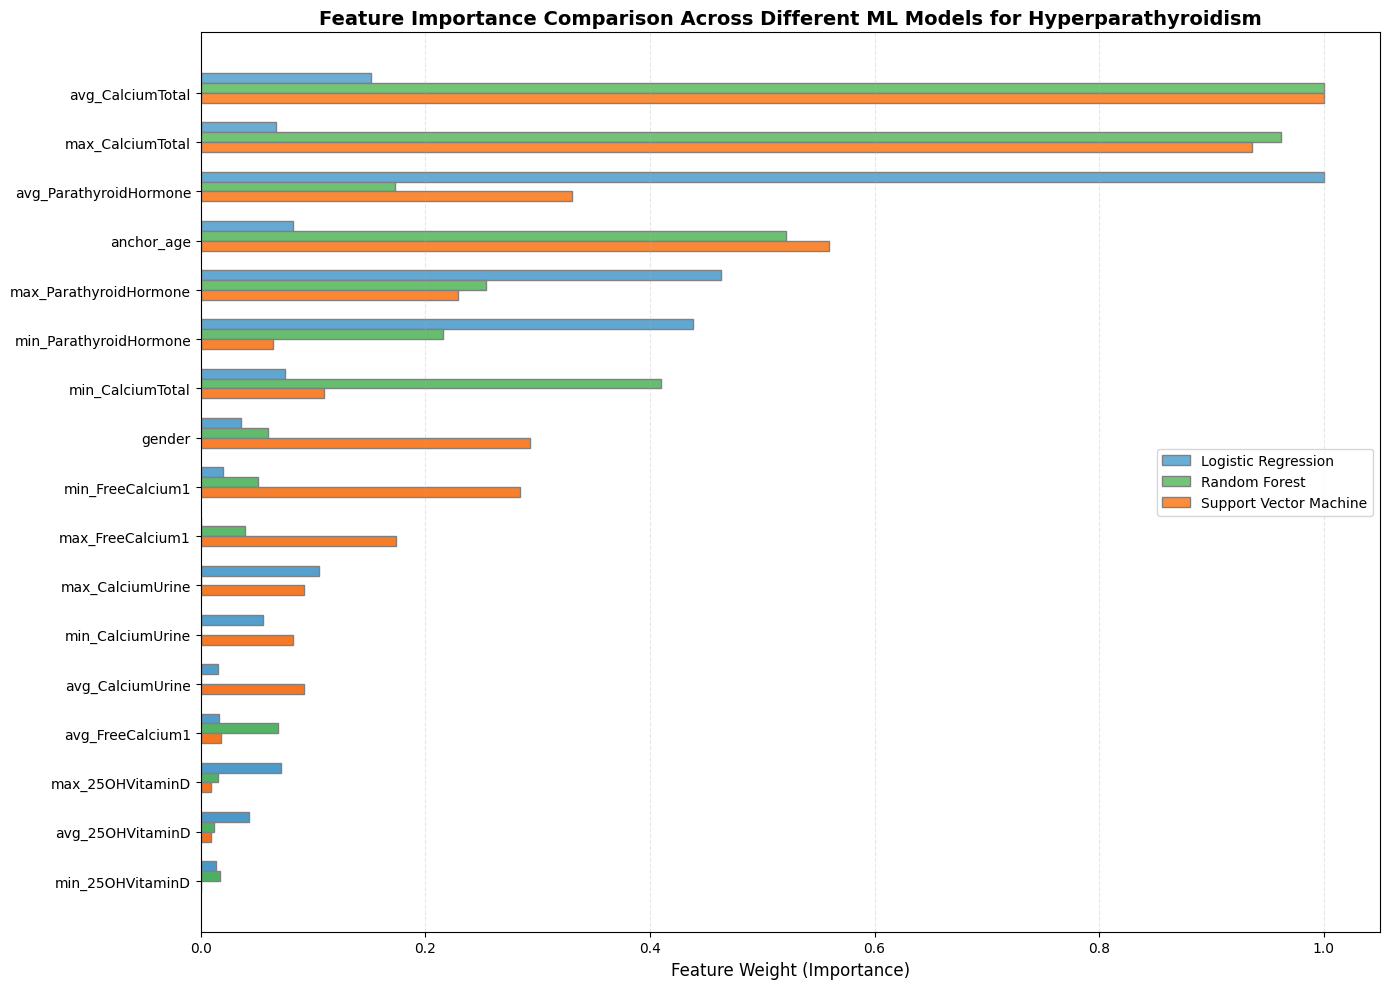

In [291]:
plot_feature_importance(feature_names, feature_weights_lr, feature_weights_rf, feature_weights_svm, target_column)

# Osteoporosis

In [269]:
target_column = 'Osteoporosis'

In [254]:
# Define the logistic regression model
logistic_model = LogisticRegression(max_iter=500)

# Define the parameter grid for logistic regression
# logistic_param_grid = {
#     'model__C': [0.001, 0.01, 0.1, 1, 10],       # Regularization strength
#     'model__solver': ['liblinear'],   # Optimization solvers
# }

logistic_param_grid = {
    'model__C': [0.01],       # Regularization strength
    'model__solver': ['liblinear'],   # Optimization solvers
}


# Call the function
feature_names, feature_weights_lr = train_and_evaluate_model(df, target_column, logistic_model, logistic_param_grid)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: {'model__C': 0.01, 'model__solver': 'liblinear'}
Best Cross-Validation ROC-AUC Score: 0.7895046461438352

Confusion Matrix:
 [[1415  569]
 [ 448 1513]]

Classification Report:
               precision    recall  f1-score   support

           0       0.76      0.71      0.74      1984
           1       0.73      0.77      0.75      1961

    accuracy                           0.74      3945
   macro avg       0.74      0.74      0.74      3945
weighted avg       0.74      0.74      0.74      3945


Test ROC-AUC Score: 0.7936264208517708


In [255]:
from sklearn.ensemble import RandomForestClassifier

# Define the Random Forest model
rf_model = RandomForestClassifier()

# Define the parameter grid for Random Forest
# rf_param_grid = {
#     'model__n_estimators': [50, 100],
#     'model__max_depth': [None, 5, 10],
#     'model__min_samples_split': [2, 5, 10]
# }

rf_param_grid = {
    'model__n_estimators': [100],
    'model__max_depth': [5],
    'model__min_samples_split': [5]
}


# Call the function
feature_names, feature_weights_rf = train_and_evaluate_model(df, target_column, rf_model, rf_param_grid)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: {'model__max_depth': 5, 'model__min_samples_split': 5, 'model__n_estimators': 100}
Best Cross-Validation ROC-AUC Score: 0.7902937520972106

Confusion Matrix:
 [[1453  531]
 [ 487 1474]]

Classification Report:
               precision    recall  f1-score   support

           0       0.75      0.73      0.74      1984
           1       0.74      0.75      0.74      1961

    accuracy                           0.74      3945
   macro avg       0.74      0.74      0.74      3945
weighted avg       0.74      0.74      0.74      3945


Test ROC-AUC Score: 0.793639529288875


In [275]:
from sklearn.svm import SVC

# Define the SVM model
svm_model = SVC(probability=True)

# Define the parameter grid for SVM
# svm_param_grid = {
#     'model__C': [0.001, 0.01, 0.1, 1],
#     'model__kernel': ['rbf', 'poly'],
#     'model__gamma': ['scale', 'auto']
# }
svm_param_grid = {
    'model__C': [0.001],
    'model__kernel': ['rbf'],
    'model__gamma': ['auto']
}

# Call the function
feature_names, feature_weights_svm = train_and_evaluate_model(df, target_column, svm_model, svm_param_grid)


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best Hyperparameters: {'model__C': 0.001, 'model__gamma': 'auto', 'model__kernel': 'rbf'}
Best Cross-Validation ROC-AUC Score: 0.7761427062062044

Confusion Matrix:
 [[365 210]
 [ 93 477]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.63      0.71       575
           1       0.69      0.84      0.76       570

    accuracy                           0.74      1145
   macro avg       0.75      0.74      0.73      1145
weighted avg       0.75      0.74      0.73      1145


Test ROC-AUC Score: 0.7851395881006864


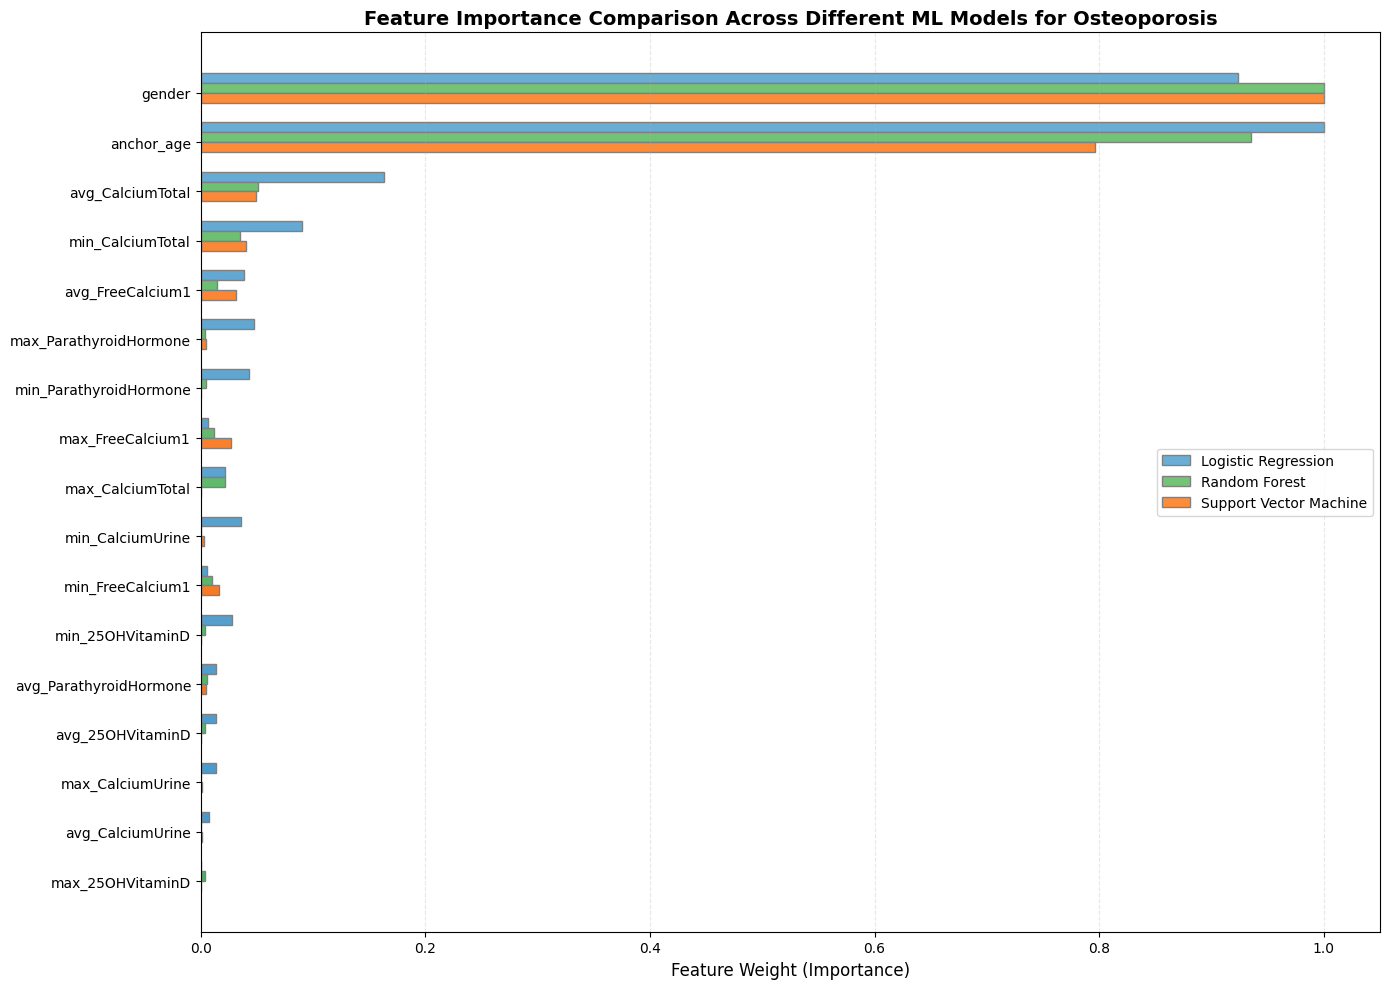

In [280]:
plot_feature_importance(feature_names, feature_weights_lr, feature_weights_rf, feature_weights_svm, target_column)